In [1]:
# Required packages
!pip install -q numpy==1.24.3 pandas==2.1.1 scikit-learn==1.3.2 scipy==1.11.3 matplotlib==3.8.0 seaborn==0.13.0 sentence-transformers==2.2.2 tensorflow==2.15.0 transformers==4.35.0 datasets==2.14.0 nltk==3.8.1 tqdm==4.66.1 --force-reinstall --no-cache-dir

In [2]:
# Libraries

import os
import gzip
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sentence_transformers import SentenceTransformer

np.random.seed(42)


In [3]:
# Directory Structure
directories = [
    'data/raw',
    'data/processed', 
    'data/embeddings',
    'results/figures',
    'results/metrics',
    'models'
]

for directory in directories:
    Path(directory).mkdir(parents=True, exist_ok=True)

In [4]:
file_path = 'data/raw/Video_Games.jsonl.gz'
file_path

'data/raw/Video_Games.jsonl.gz'

In [5]:
# Load and sample 150K reviews 
sample_size = 150000
samples = []

with gzip.open(file_path, 'rt', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= sample_size:
            break
        try:
            review = json.loads(line.strip())
            samples.append(review)
        except json.JSONDecodeError:
            continue

df = pd.DataFrame(samples)

print(f"\nDataset shape: {df.shape}")


Dataset shape: (150000, 10)


In [6]:
# First few rows
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4.0,It’s pretty sexual. Not my fav,I’m playing on ps5 and it’s interesting. It’s...,[],B07DJWBYKP,B07DK1H3H5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1608186804795,0,True
1,5.0,Good. A bit slow,Nostalgic fun. A bit slow. I hope they don’t...,[],B00ZS80PC2,B07SRWRH5D,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1587051114941,1,False
2,5.0,... an order for my kids & they have really en...,This was an order for my kids & they have real...,[],B01FEHJYUU,B07MFMFW34,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,1490877431000,0,True
3,5.0,Great alt to pro controller,"These work great, They use batteries which is ...",[],B07GXJHRVK,B0BCHWZX95,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,1577637634017,0,True
4,5.0,solid product,I would recommend to anyone looking to add jus...,[],B00HUWA45W,B00HUWA45W,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,1427591932000,0,True


In [7]:
# Intial Data Exploration 
print(f"Total reviews: {len(df):,}")
print(df.dtypes)
print(df.isnull().sum()[df.isnull().sum() > 0])
print(f"\nRating distribution:")
print(df['rating'].value_counts().sort_index())

Total reviews: 150,000
rating               float64
title                 object
text                  object
images                object
asin                  object
parent_asin           object
user_id               object
timestamp              int64
helpful_vote           int64
verified_purchase       bool
dtype: object
Series([], dtype: int64)

Rating distribution:
rating
1.0    13674
2.0     7473
3.0    12189
4.0    21827
5.0    94837
Name: count, dtype: int64


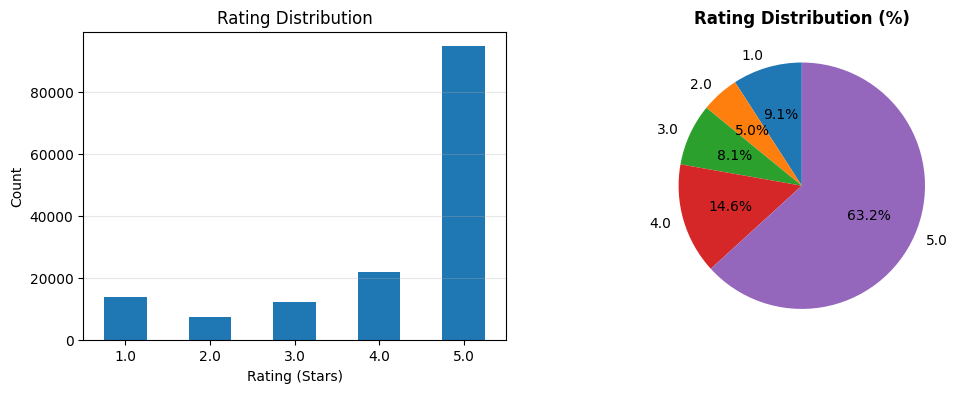

In [8]:
# Rating distribution plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
rating_counts = df['rating'].value_counts().sort_index()

rating_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Rating Distribution')
axes[0].set_xlabel('Rating (Stars)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

rating_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Rating Distribution (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')

plt.savefig('results/figures/rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Preprocessing 
df_clean = df.dropna(subset=['text', 'rating']).copy()
df_clean = df_clean[df_clean['text'].str.len() >= 10].copy()

# Mapping to sentiment: 0=Negative (1-2 stars), 1=Neutral (3 stars), 2=Positive (4-5 stars)
df_clean['sentiment'] = df_clean['rating'].apply(
    lambda x: 0 if x <= 2.0 else (1 if x == 3.0 else 2)
)

print(f"Cleaned: {len(df_clean):,}")
for sent, label in enumerate(['Negative', 'Neutral', 'Positive']):
    count = (df_clean['sentiment'] == sent).sum()
    print(f"  {label}: {count:,} ({count/len(df_clean)*100:.1f}%)")

Cleaned: 143,156
  Negative: 20,946 (14.6%)
  Neutral: 11,869 (8.3%)
  Positive: 110,341 (77.1%)


In [10]:
# Text statistics
df_clean['text_length'] = df_clean['text'].str.len()
df_clean['word_count'] = df_clean['text'].str.split().str.len()

print(f"  Mean Character length: {df_clean['text_length'].mean():.0f}, Median: {df_clean['text_length'].median():.0f}")
print(f"  Mean Word Count: {df_clean['word_count'].mean():.0f}, Median: {df_clean['word_count'].median():.0f}")

  Mean Character length: 364, Median: 150
  Mean Word Count: 67, Median: 28


In [11]:
# Stratified sampling to 100K
target_total = 100000
sentiment_dist = df_clean['sentiment'].value_counts(normalize=True)
samples_per_class = {sent: int(target_total * pct) for sent, pct in sentiment_dist.items()}

df_sampled = df_clean.groupby('sentiment', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), samples_per_class[x.name]), random_state=42)
).reset_index(drop=True)

print(f"{len(df_sampled):,} reviews")
for sent, label in enumerate(['Negative', 'Neutral', 'Positive']):
    count = (df_sampled['sentiment'] == sent).sum()
    print(f"  {label}: {count:,} ({count/len(df_sampled)*100:.1f}%)")

99,998 reviews
  Negative: 14,631 (14.6%)
  Neutral: 8,290 (8.3%)
  Positive: 77,077 (77.1%)


In [12]:
# Train/Val/Test Split 80/10/10
train_df, temp_df = train_test_split(df_sampled, test_size=0.2, stratify=df_sampled['sentiment'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentiment'], random_state=42)

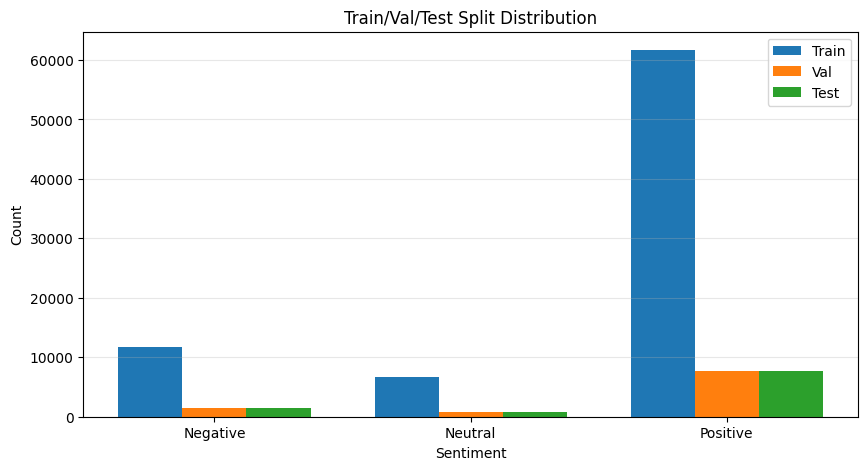

In [13]:
# Split distribution 
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(3)
width = 0.25
labels = ['Negative', 'Neutral', 'Positive']

train_counts = [sum(train_df['sentiment'] == i) for i in range(3)]
val_counts = [sum(val_df['sentiment'] == i) for i in range(3)]
test_counts = [sum(test_df['sentiment'] == i) for i in range(3)]

ax.bar(x - width, train_counts, width, label='Train')
ax.bar(x, val_counts, width, label='Val')
ax.bar(x + width, test_counts, width, label='Test')

ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.set_title('Train/Val/Test Split Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.savefig('results/figures/split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Generate Embeddings (384-dim)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [15]:
train_embeddings = embedding_model.encode(train_df['text'].tolist(), batch_size=32, 
                                          show_progress_bar=True, convert_to_numpy=True)
print(f"Train: {train_embeddings.shape}")

Batches:   0%|          | 0/2500 [00:00<?, ?it/s]

Train: (79998, 384)


In [16]:
val_embeddings = embedding_model.encode(val_df['text'].tolist(), batch_size=32, 
                                        show_progress_bar=True, convert_to_numpy=True)
print(f"Val: {val_embeddings.shape}")

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Val: (10000, 384)


In [17]:
test_embeddings = embedding_model.encode(test_df['text'].tolist(), batch_size=32, 
                                         show_progress_bar=True, convert_to_numpy=True)
print(f"Test: {test_embeddings.shape}")

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Test: (10000, 384)


In [18]:
# Compute Class Weights
y_train = train_df['sentiment'].values
y_val = val_df['sentiment'].values
y_test = test_df['sentiment'].values

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:")
for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    print(f"  {label}: {class_weights[i]:.4f}")

Class weights:
  Negative: 2.2782
  Neutral: 4.0208
  Positive: 0.4325


In [19]:
# Save the text data
np.save('data/processed/X_train_text.npy', train_df['text'].values, allow_pickle=True)
np.save('data/processed/X_val_text.npy', val_df['text'].values, allow_pickle=True)
np.save('data/processed/X_test_text.npy', test_df['text'].values, allow_pickle=True)

np.save('data/embeddings/train_embeddings.npy', train_embeddings)
np.save('data/embeddings/val_embeddings.npy', val_embeddings)
np.save('data/embeddings/test_embeddings.npy', test_embeddings)

np.save('data/processed/y_train.npy', y_train)
np.save('data/processed/y_val.npy', y_val)
np.save('data/processed/y_test.npy', y_test)

with open('data/processed/class_weights.pkl', 'wb') as f:
    pickle.dump(class_weight_dict, f)

In [20]:
# Save DataFrames 

train_df[['text', 'sentiment', 'rating']].to_csv('data/processed/train.csv', index=False)
val_df[['text', 'sentiment', 'rating']].to_csv('data/processed/val.csv', index=False)
test_df[['text', 'sentiment', 'rating']].to_csv('data/processed/test.csv', index=False)
